In [18]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score

In [19]:
# Only for visualization of process
from tqdm import notebook
def tqdm(x, **kargs):
    return notebook.tqdm(x, leave=False, **kargs)

## Load data

In [113]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [114]:
# 550 data with 300 features
print(x_train.shape)

(550, 300)


In [115]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [116]:
def cross_validation(x_train, y_train, k=5, shuffle=True):
    data_indices = np.arange(x_train.shape[0])
    if shuffle is True:
        np.random.shuffle(data_indices)
    kfold = []
    k_split = np.full(k, x_train.shape[0] // k)
    first_indices = np.arange(x_train.shape[0] % k)
    k_split[first_indices] += 1
    start = 0
    end = 0
    for eid, each_split in enumerate(k_split):
        end += each_split
        training_set = np.concatenate((data_indices[:start], data_indices[end:]))
        validation_set = data_indices[start:end]
        kfold.append([training_set, validation_set])
        start += each_split
    return kfold

In [117]:
K = 10
kfold_data = cross_validation(x_train, y_train, k=K, shuffle=True)
assert len(kfold_data) == 10  # should contain 10 fold of data
assert len(kfold_data[0]) == 2  # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 55  # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C”, “kernel” and “gamma” to find the best parameters by cross-validation.

In [118]:
C = [1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3, 1e4]
G = [1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3, 1e4]

best_parameters = (0, 0)
best_score = 0
all_score = []

# K-fold cross validation
for cost in tqdm(C, desc='All costs: '):
    for gamma in tqdm(G, desc='All gammas: '):
        avg_score = 0
        for training_set, validation_set in kfold_data:
            clf = SVC(C=cost, kernel='rbf', gamma=gamma)
            clf.fit(x_train[training_set], y_train[training_set])
            avg_score += clf.score(x_train[validation_set], y_train[validation_set])
        avg_score /= K
        all_score.append(avg_score)
        if avg_score >= best_score:
            best_parameters = (gamma, cost)
            best_score = avg_score
all_score = np.array(all_score)
# print(all_score)

In [119]:
print(best_parameters)
print(best_score)

(0.001, 10000.0)
0.9018181818181817


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like the reference image ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

In [120]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

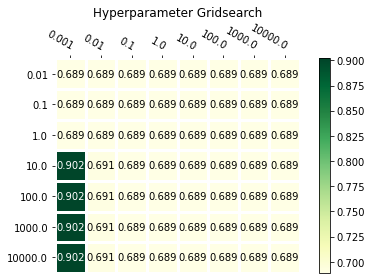

In [121]:
all_score_reshape = np.array(all_score).reshape(len(C), len(G))
# print(all_score_reshape)

fig, ax = plt.subplots()

im, cbar = heatmap(all_score_reshape, C, G, ax=ax,
                   cmap="YlGn", cbarlabel="")
texts = annotate_heatmap(im, valfmt="{x:.3f}")

plt.title('Hyperparameter Gridsearch')
fig.tight_layout()
plt.show()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set. **You accuracy should over 0.85**

In [122]:
# gamma, cost
print(best_parameters)

(0.001, 10000.0)


In [123]:
best_model = SVC(C=best_parameters[1], kernel='rbf', gamma=best_parameters[0])
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

Accuracy score:  0.8958333333333334


## Question 5
Compare the performance of each model you have implemented from HW1

### HW1 w/ LR

In [96]:
train_df = pd.read_csv("../HW1/train_data.csv")
x_train, y_train = train_df['x_train'].values, train_df['y_train'].values

In [74]:
def training(iteration, learning_rate, theta):
    total_loss = []
    for iteration in tqdm(range(n_iteration), desc='Iterations: '):
        y_pred_theta0 = []
        y_pred_theta1 = []
        loss = 0

        for i in range(len(x_train)):
            y_pred = theta[0] + theta[1] * x_train[i]
            y_pred_minus_true = y_pred - y_train[i]
            loss += y_pred_minus_true ** 2
            y_pred_theta0.append(y_pred_minus_true)
            y_pred_theta1.append(y_pred_minus_true * x_train[i])

        y_pred_theta0 = np.array(y_pred_theta0)
        partial_theta0 = np.sum(y_pred_theta0, axis=0) / len(x_train)
        y_pred_theta1 = np.array(y_pred_theta1)
        partial_theta1 = np.sum(y_pred_theta1, axis=0) / len(x_train)
        loss /= len(x_train)
        total_loss.append(loss)
        theta[0] = theta[0] - learning_rate * partial_theta0
        theta[1] = theta[1] - learning_rate * partial_theta1

        if iteration % 10000 == 0:
            print("Iteration = {}, loss = {}".format(iteration, loss))
    return theta, total_loss

In [75]:
n_iteration = 30000
learning_rate = 1e-4
sigma = 1
theta = np.random.normal(0, sigma, 2)
theta, total_loss = training(n_iteration, learning_rate, theta)
print(theta)
print("training loss is {}".format(total_loss[n_iteration - 1]))

Iteration = 0, loss = [2.45570688]
Iteration = 10000, loss = [0.5627929]
Iteration = 20000, loss = [0.30731548]
[0.75176437 0.75205624]
training loss is [0.27277749]


In [76]:
test_data = pd.read_csv("../HW1/test_data.csv")
x_test, y_test = test_data['x_test'], test_data['y_test']

In [77]:
def model(x, theta):
    y_pred = []
    for i in range(len(x)):
        y_pred.append(theta[0] + theta[1] * x[i])
    return y_pred

In [78]:
y_pred = model(x_test, theta)

In [79]:
def MSE(y_pred, y_test):
    error = 0
    for i in range(len(y_pred)):
        error += (y_pred[i] - y_test[i]) ** 2
    error /= len(y_pred)
    return error

In [80]:
mse_lr = MSE(y_pred, y_test)
print("MSE error = {}".format(mse_lr))

MSE error = 0.07930168315663533


### HW1 w/ SVR

In [128]:
train_df = pd.read_csv("../HW1/train_data.csv")
x_train = train_df['x_train'].to_numpy().reshape(-1,1)
y_train = train_df['y_train'].to_numpy().reshape(-1,1).ravel()

test_df = pd.read_csv("../HW1/test_data.csv")
x_test = test_df['x_test'].to_numpy().reshape(-1,1)
y_test = test_df['y_test'].to_numpy().reshape(-1,1).ravel()

In [129]:
K = 10
kfold_data = cross_validation(x_train, y_train, k=K, shuffle=True)

In [130]:
## your code
C = [1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3, 1e4]
G = [1e-3, 1e-2, 1e-1, 1e-0, 1e1, 1e2, 1e3, 1e4]

best_parameters = (0, 0)
best_score = 1e3
all_score = []

# K-fold cross validation
for cost in tqdm(C, desc='All costs: '):
    for gamma in tqdm(G, desc='All gammas: '):
        avg_score = 0
        for training_set, validation_set in kfold_data:
            clf = SVR(C=cost, kernel='rbf', gamma=gamma)
            clf.fit(x_train[training_set], y_train[training_set])
            y_pred = clf.predict(x_train[validation_set])
            avg_score += MSE(y_pred, y_train[validation_set])
#             avg_score += clf.score(x_train[validation_set], y_train[validation_set])
        avg_score /= K
        all_score.append(avg_score)
        if avg_score <= best_score:
            best_parameters = (gamma, cost)
            best_score = avg_score
all_score = np.array(all_score)

In [131]:
print(best_parameters)
print(best_score)

(0.001, 1000.0)
0.27035124833217716


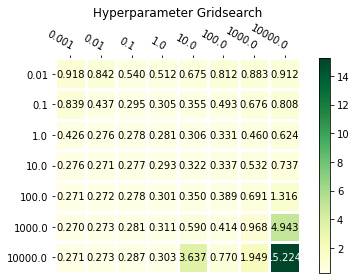

In [132]:
all_score_reshape = np.array(all_score).reshape(len(C), len(G))
# print(all_score_reshape)

fig, ax = plt.subplots()

im, cbar = heatmap(all_score_reshape, C, G, ax=ax,
                   cmap="YlGn", cbarlabel="")
texts = annotate_heatmap(im, valfmt="{x:.3f}")

plt.title('Hyperparameter Gridsearch')
fig.tight_layout()
plt.show()

In [133]:
best_model = SVR(C=best_parameters[1], kernel='rbf', gamma=best_parameters[0])
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)
# print(y_pred)
SE = 0
for idx, y in enumerate(y_pred):
    error = (y_test[idx] - y_pred[idx]) ** 2
    SE += error
SE /= len(y_pred)
print("Accuracy score: ", SE)

Accuracy score:  0.07200436935355771


In [134]:
print("Mean square error of Linear regression: {}".format(mse_lr))
print("Mean square error of SVM regresssion model: {}".format(SE))

Mean square error of Linear regression: 0.07930168315663533
Mean square error of SVM regresssion model: 0.07200436935355771
